![astropy logo](http://astropy.readthedocs.org/en/stable/_images/astropy_banner.svg)

# Introduction to [`astropy`](http://astropy.readthedocs.org/en/stable/)

with Brett Morris ([@brettmor](http://twitter.com/brettmor))

*** 

## Setup

Dependencies for this talk include: [astropy](http://astropy.readthedocs.org/en/stable/install.html) (plus numpy and matplotlib) and optionally [astroquery](https://astroquery.readthedocs.org/en/latest/#installation), [astroplan](https://astroplan.readthedocs.org/en/latest/installation.html#id2) 

Installations via `pip`:
```
pip install astropy
# Optionally: pip install astroquery astroplan
```

If this is the first time you've installed astropy, you should open a Python shell *right away* and run `import astropy`. Some parts of the package get built on the first import and take a few minutes to complete.

***

### Outline

In this tour of `astropy`, we'll tinker with three of the most fundamental modules of `astropy`: `units`, `time` and `coordinates`, experiment with the cosmology module, and learn about `astropy`-affiliated packages including `astroquery` and `astroplan`.

1. `astropy.units`
2. `astropy.time`
3. `astropy.coordinates`
4. `astropy.cosmology`
5. `astropy`-[affiliated packages](http://www.astropy.org/affiliated/): `astroquery` & `astroplan`

*** 
 
## 1) [`astropy.units`](http://astropy.readthedocs.org/en/latest/units/): Problem sets are about to get easier

One of the modules most central to `astropy` is the `units` module, which will save you lots of time. 

In [4]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# Convention for importing `astropy.units`:
import astropy.units as u

d_galactic_center = u.Quantity(8e3, unit=u.pc)
# or equivalently:
d_galactic_center = 8e3*u.pc

Astropy quantities are like `numpy` arrays and share many of their methods. 

In [32]:
d_galactic_center

<Quantity 8000.0 pc>

If you're self-abusive, imperial units are supported:

In [10]:
from astropy.units.imperial import foot
d_galactic_center.to(foot)

<Quantity 8.098891289940134e+20 ft>

What is the light-travel time to the galactic center? ($\Delta t = \Delta x / c$)

In [11]:
from astropy.constants import c, G, M_sun, M_earth, M_jup

dt = d_galactic_center/c
dt.to(u.second)

<Quantity 823417000428.2607 s>

Metric prefixes accepted (try `M` for mega, `p` for pico, etc.)

In [12]:
dt.to(u.gigasecond)

<Quantity 823.4170004282606 Gs>

Compute the light travel time from the Sun to solar system planets: 

In [13]:
# Semimajor axes to planets in AU
semimajor_axes_list = [0.387, 0.723, 1.000, 1.524, 5.203, 9.523, 19.208, 30.087]

semimajor_axes = u.Quantity(semimajor_axes_list, unit=u.AU)
(semimajor_axes/c).to(u.hour)

<Quantity [ 0.05364301, 0.10021679, 0.13861244, 0.21124536, 0.72120053,
            1.32000627, 2.66246775, 4.17043248] h>

***

## 2) [`astropy.time`](http://astropy.readthedocs.org/en/latest/time/index.html): Time objects for humans

There are many distinct and confusing time systems used in astronomy, and the `astropy.time` module provides a convenient means of translating between them – never code your own JD-to-ISO time converter or try to remember whether or not the difference between JD and MJD has a 0.5 in it again:

In [14]:
# The astropy.time.Time object contains a time in a specified format
from astropy.time import Time

# If the input format is not specified, it will guess. Here's an ISO formatted string:
t = Time('2000-01-01 12:34:56')
t.jd

2451545.0242592595

Here's a Julian Date:

In [15]:
t = Time(2451545.0242592595, format='jd')
t

<Time object: scale='utc' format='jd' value=2451545.02426>

Convert between time formats by calling `t.iso`, `t.mjd`, `t.datetime`, etc.

In [36]:
Time('2000-01-01 12:35').jd

2451545.0243055555

By default, the scale (or time standard) is set to **UTC**, which is defined to keep an integer number of seconds per day. There are other time standards like **UT1** which are defined by the rotation of the Earth (see [my blog post on time standards](http://bmmorris.blogspot.com/2015/06/ut1-utc-and-astropy.html) for more background). Converting between the two can be messy, but not with astropy:

In [37]:
print('Available time scales: {0}'.format(', '.join(Time.SCALES)))
t.scale

Available time scales: tai, tcb, tcg, tdb, tt, ut1, utc


u'utc'

In [38]:
t.ut1

<Time object: scale='ut1' format='jd' value=2451545.02426>

*Aside*: If converting between UTC and UT1 raises an `IndexError` like this, 
```
IndexError: (some) times are outside of range covered by IERS table.
```
it's because you need more up-to-date Earth rotation data since the Earth's rate of rotation is constantly changing. See the `astropy.time` docs on [Transformation offsets](http://astropy.readthedocs.org/en/stable/time/index.html#transformation-offsets) to update your Earth rotation data.

Lastly, arrays of times can be generated from numpy arrays:

In [109]:
t = Time.now() + np.linspace(0, 1, 10)*u.year
t.jd

array([ 2457319.3555631 ,  2457359.93889643,  2457400.52222977,
        2457441.1055631 ,  2457481.68889643,  2457522.27222977,
        2457562.8555631 ,  2457603.43889643,  2457644.02222977,
        2457684.6055631 ])






***




## 3) [`astropy.coordinates`](http://astropy.readthedocs.org/en/latest/coordinates/index.html)

![XKCD comic](http://imgs.xkcd.com/comics/standards.png)

Convert the position of your target from one coordinate system to another without opening a reference book!

Let's define the galactic center in the natural coordinate system:

In [16]:
from astropy.coordinates import SkyCoord

gal_center = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
print(gal_center)

<SkyCoord (Galactic): (l, b) in deg
    (0.0, 0.0)>


Now let's say you have to tell an observer where the galactic center is in ICRS coordinates:

In [17]:
gal_center.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (266.40498829, -28.93617776)>

You can resolve targets by name with the `from_name` class method. Try it with your favorite star object:

In [18]:
sgr_a = SkyCoord.from_name('Sgr A*')
print(sgr_a)

<SkyCoord (ICRS): (ra, dec) in deg
    (266.4168262, -29.0077969)>


Let's represent these coordinates in various formats with `.degree`, `.hourangle`:

In [19]:
sgr_a.ra

<Longitude 266.4168262 deg>

and experiment with the string outputs you'd use in a proposal, like `dms`, `hmsdms`, `decimal`:

In [20]:
sgr_a.to_string(style='hmsdms', sep=":")

u'17:45:40.0383 -29:00:28.0688'

`SkyCoord` objects can be initialized from lots of frames:

In [21]:
c1 = SkyCoord(10, 20, unit="deg")
c2 = SkyCoord(ra='18h36m56.3363s', dec='+38d47m01.2802s')
c3 = SkyCoord(w=0, u=1, v=2, unit='kpc', frame='galactic', representation='cartesian')

c2.separation(c3)

<Angle 46.79182272650832 deg>

With a specified location on Earth, you can compute alt/az coordinates for any `SkyCoord`

In [22]:
from astropy.coordinates import EarthLocation, AltAz

# Define Earth location:
longitude, latitude, elevation = (-122.3331*u.deg, 47.6097*u.deg, 0*u.m)
seattle = EarthLocation.from_geodetic(longitude, latitude, elevation)

# Define alt/az frame:
alt_az_frame = AltAz(obstime=Time('2005-06-07 08:09:10'), location=seattle)

# Transform the coordinate to the new reference frame, and print
sgr_a_altaz = sgr_a.transform_to(alt_az_frame)
sgr_a_altaz.to_string(style='hmsdms', sep=':')

u'11:21:34.3181 +12:46:20.73'

***


## 4) [`astropy.cosmology`](http://astropy.readthedocs.org/en/latest/cosmology/): Get standard cosmologies fast!

First, choose a cosmology (e.g.: `Planck13`, `WMAP9`) and get $H_0$:

In [21]:
from astropy.cosmology import WMAP9 as cosmo

# Give me the reference for this cosmology:
print(cosmo.__doc__)

cosmo.H(z=0)

WMAP9 instance of FlatLambdaCDM cosmology

(from Hinshaw et al. 2013, ApJS, 208, 19, doi: 10.1088/0067-0049/208/2/19. Table 4 (WMAP9 + eCMB + BAO + H0, last column))


<Quantity 69.32 km / (Mpc s)>

In [125]:
cosmo.angular_diameter_distance(z=1)

<Quantity 1681.535321665544 Mpc>

In [126]:
cosmo.luminosity_distance(z=1)

<Quantity 6726.141286662176 Mpc>

In cosmology class you'll still have to learn to solve these from scratch, but you can double check yourself like so: 

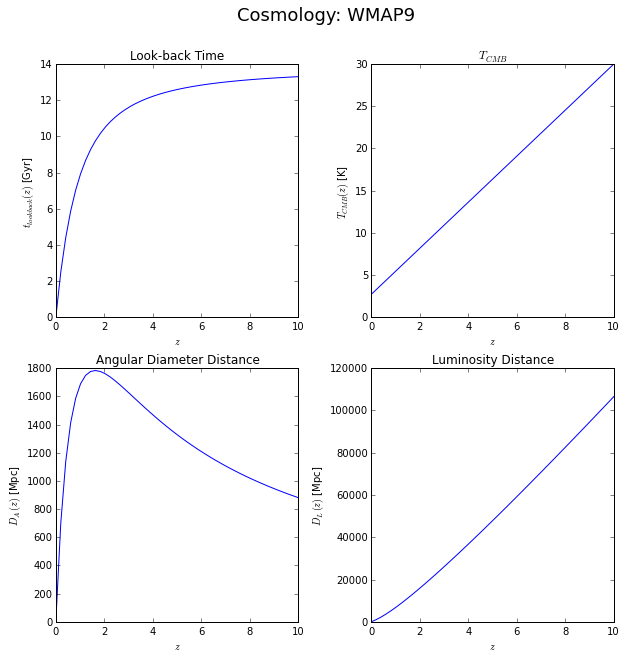

In [25]:
z = np.linspace(0, 10, 50)

# Compute some parameters
t_lookback = cosmo.lookback_time(z)
T_cmb = cosmo.Tcmb(z)
D_A = cosmo.angular_diameter_distance(z)
D_L = cosmo.luminosity_distance(z)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].plot(z, t_lookback)
ax[0, 0].set(title='Look-back Time', xlabel='$z$', 
             ylabel=r'$t_{{lookback}}(z)$ [{0}]'.format(t_lookback.unit))

ax[0, 1].plot(z, T_cmb)
ax[0, 1].set(title='$T_{CMB}$', xlabel='$z$', 
             ylabel='$T_{{CMB}}(z)$ [{0}]'.format(T_cmb.unit))

ax[1, 0].plot(z, D_A)
ax[1, 0].set(title='Angular Diameter Distance', xlabel='$z$', 
             ylabel=r'$D_A(z)$ [{0}]'.format(D_A.unit))

ax[1, 1].plot(z, D_L)
ax[1, 1].set(title='Luminosity Distance', xlabel='$z$', 
             ylabel=r'$D_L(z)$ [{0}]'.format(D_L.unit))

fig.subplots_adjust(wspace=0.3)
fig.suptitle('Cosmology: {0}'.format(cosmo.name), fontsize=18);

***


## 5a) Affiliated Package: [`astroquery`](http://astroquery.readthedocs.org)

Since `astropy` is a collection of fundamental tools, lots of packages have been built on top of `astropy` to provide easy access to specific functionality. One of those is `astroquery`, which allows you to query astronomical databases with ease.

Let's query for the SIMBAD entry for a planet hosting star, HD 189733:

In [56]:
from astroquery.simbad import Simbad

table = Simbad.query_object('HD 189773')
table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,unicode416,unicode416,int16,int16,float32,float32,int16,unicode32,unicode32,object
HD 189773,20 05 10.8954,-61 30 25.967,8,8,62.600,55.680,90,B,,1998A&A...335L..65H


Let's query Vizier for the photometry of stars in the globular cluster NGC 6652 from [
Ortolani et al. 1994](http://cdsads.u-strasbg.fr/cgi-bin/nph-bib_query?1994A%26A...286..444O&db_key=AST&nosetcookie=1). The [`astropy.table`](http://astropy.readthedocs.org/en/latest/table/) that is returned to you will have the same information as [this Vizier query page](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/A+A/286/444).

In [26]:
from astroquery.vizier import Vizier

#catalog_list = Vizier.find_catalogs("Landolt 1992")
catalog_list = Vizier.find_catalogs("J/A+A/286/444") # Table from Ortolani+ 1994
catalogs = Vizier.get_catalogs(catalog_list.keys())
Vizier.ROW_LIMIT = -1        # Otherwise would only show first 50 values
landolt_table = catalogs[0]  # This is the table with the data

print("Available columns: {0}".format(landolt_table.columns.keys()))

Available columns: ['Seq', 'Xpos', 'Ypos', 'Vmag', 'B-V']


And let's make a quick HR diagram for these objects:

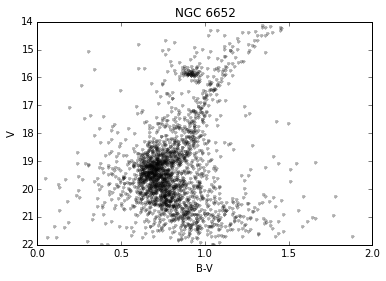

In [27]:
# Grab data from the columns of the `astropy.table.Table`
b_minus_v = landolt_table['B-V'].data
Vmag = landolt_table['Vmag'].data

# Plot color magnitude diagram
ax = plt.gca()
ax.plot(b_minus_v, Vmag, 'k.', alpha=0.3)
ax.invert_yaxis()
ax.set(xlim=[0.0, 2.0], ylim=[22, 14],
       xlabel='B-V', ylabel='V', title='NGC 6652')
plt.show()

## 5b) Affiliated Package: [`astroplan`](https://astroplan.readthedocs.org/en/latest/)

`astroplan` is an `astropy`-affiliated package that helps you calculate when objects are observable. Here's a quick example for determining which targets are visible right now from Apache Point Observatory:

In [23]:
from astroplan import Observer, FixedTarget

# Targets are stored as `astroplan.FixedTarget` objects
target_names = ['Polaris', 'Sirius', 'Vega', 'Rigel']
bright_targets = [FixedTarget.from_name(target) for target in target_names]

# Observatories are `astroplan.Observer` objects
apache_point = Observer.at_site("APO")

# Which targets are visible right now?
apache_point.target_is_up(Time('2001-12-21 10:00:00'), bright_targets)

[True, True, False, True]

Now let's see which of those targets are visible over a time range of the next ten days, given the following constraints: 

* Observations must occur between civil twilights
* The altitude of the target must be $20^\circ < $alt$ < 85^\circ$

In [26]:
from astroplan import AtNightConstraint, AltitudeConstraint, observability_table

landolt_targets = [FixedTarget(coord=coord, name=name) 
                   for coord, name in zip(landolt_standards, names)]
time_range = Time.now() + np.array([0, 10])*u.day

constraints = [AtNightConstraint.twilight_civil(),
               AltitudeConstraint(min=27*u.deg, max=85*u.deg)]

observability_table(constraints, apache_point, bright_targets, time_range=time_range)

target name,ever observable,always observable,fraction of time observable
string56,bool,bool,float64
Polaris,True,False,0.502083333333
Sirius,True,False,0.183333333333
Vega,True,False,0.15
Rigel,True,False,0.270833333333


Let's track that target's motion through the sky for the next ten hours in a plot: 

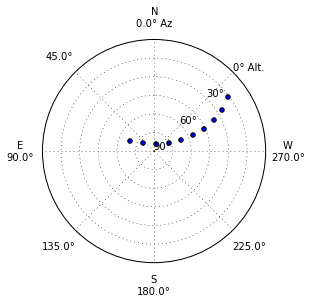

In [39]:
from astroplan.plots import plot_sky

# Plot at times: 
plot_times = Time.now() + np.linspace(0, 8, 10)*u.hour

plot_sky(bright_targets[2], apache_point, plot_times);

### Putting the affiliated packages together: 
Which [Landolt (1992)](http://adsabs.harvard.edu/abs/1992AJ....104..340L) standard stars are up tonight?

In [37]:
from astroplan import AirmassConstraint

# Get the objects from Landolt (1992) via astroquery
catalog_list = Vizier.find_catalogs('Landolt 1992')
catalogs = Vizier.get_catalogs(catalog_list.keys())
Vizier.ROW_LIMIT = -1   # Otherwise would only show first 50 values
catalog_table = catalogs[0] # This is the table with the data

# Make `astroplan.FixedTarget` objects for each standard star
RAs = u.Quantity(catalog_table['_RAJ2000'].data, unit=u.deg)
Decs = u.Quantity(catalog_table['_DEJ2000'].data, unit=u.deg)
names = list(catalog_table['SimbadName'].data)
landolt_standards = SkyCoord(ra=RAs, dec=Decs)
target_list = [FixedTarget(coord=coord, name=name) 
               for coord, name in zip(landolt_standards, names)]

# Figure out when "tonight" is
present_time = Time.now()
if not apache_point.is_night(present_time):
    # If it's currently day time at runtime, find time of sunset and sunrise
    tonight_start = apache_point.sun_set_time(present_time, which='next')
    tonight_end = apache_point.sun_rise_time(present_time, which='next')
else:
    # Otherwise find time to next sunrise
    tonight_start = present_time
    tonight_end = apache_point.sun_rise_time(present_time, which='next')

# Constrain our observations to be between astronomical twilights and 
# between altitudes of 27-85 degrees
constraints = [AtNightConstraint.twilight_astronomical(),
               AltitudeConstraint(min=27*u.deg, max=85*u.deg),
               AirmassConstraint(max=1.5)]

# Calculate which stars are observable
table = observability_table(constraints, apache_point, target_list, 
                            time_range=Time([tonight_start, tonight_end]))
print(table)

   target name     ever observable always observable fraction of time observable
------------------ --------------- ----------------- ---------------------------
     [L92b] TPHE A           False             False                         0.0
     [L92b] TPHE B           False             False                         0.0
     [L92b] TPHE C           False             False                         0.0
     [L92b] TPHE D           False             False                         0.0
     [L92b] TPHE E           False             False                         0.0
     [L92b] TPHE F           False             False                         0.0
     [L92b] TPHE G           False             False                         0.0
        PG0029+024            True             False              0.407407407407
        PG0039+049            True             False              0.407407407407
         SA 92 309            True             False               0.37037037037
               ...          